In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.notebook_helper_functions.notebook14 as funcs
# import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

# import statistics
# import multiprocessing as mp
import numpy as np
import pandas as pd
# import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from statistics import NormalDist

<a name="block_size"></a>
### 1. Experiment 1: block size by lag order and difference degree

In [2]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-block_size.parquet' 
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,9,0,0,0,3.186607,1.158957
1,0,ARIMA,9,0,1,0,0.998434,-0.001568
2,0,ARIMA,9,0,2,0,2.087234,0.735840


Winning control sample mean SMAPE score: 1.283261992926774
lag_order: [0, 1, 2]
difference_degree: [0, 1, 2]
moving_average_order: [0]
block_size: [9, 18, 37]


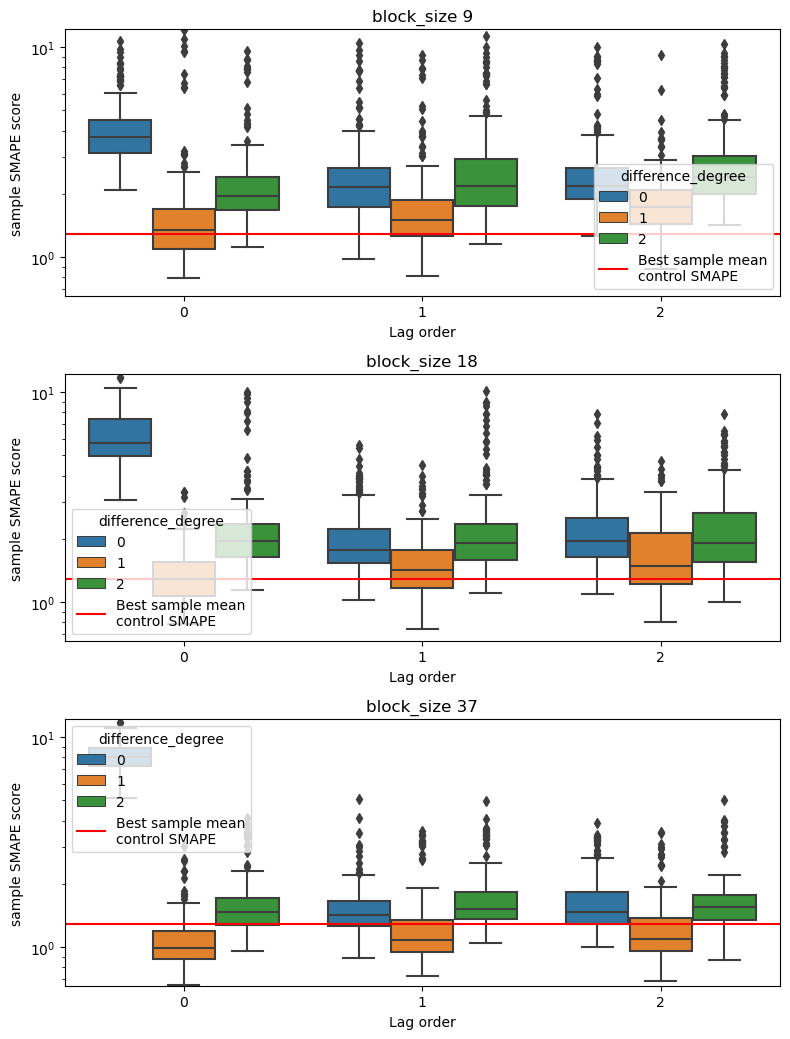

In [3]:
plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    parameter = 'block_size',
    hue_by = 'difference_degree'
)

In [4]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-moving_average_order.parquet'
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,37,0,0,0,7.935237,2.071313
1,0,ARIMA,37,0,0,1,4.869520,1.582995
2,0,ARIMA,37,0,0,2,3.672495,1.300871


Winning control sample mean SMAPE score: 1.085717400437214
lag_order: [0, 1, 2]
difference_degree: [0, 1, 2]
moving_average_order: [0, 1, 2]
block_size: [37]


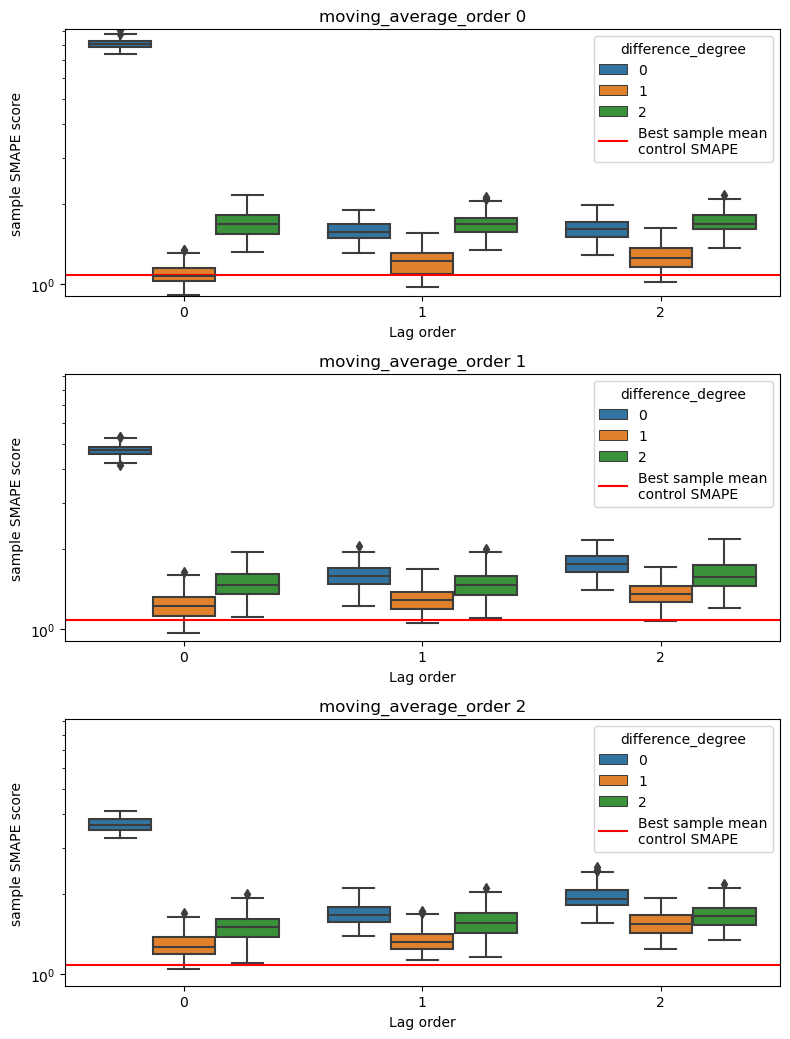

In [5]:
plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    parameter = 'moving_average_order',
    hue_by = 'difference_degree'
)